In [47]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.utils import load_coco_annotations, create_mask_for_image, save_mask_image
from pathlib import Path
from tqdm import tqdm
%matplotlib inline

# Make Directory Structure and download data

In [ ]:
####### Make the directory structure
import os

os.makedirs("data/raw/images", exist_ok=True)
os.makedirs("data/processed/images", exist_ok=True)
os.makedirs("data/processed/masks", exist_ok=True)

In [4]:
######## Download the files and store is where required
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip -d data/raw/
!unzip annotations_trainval2017.zip -d data/raw/
!mv data/raw/val2017/* data/raw/images/
!cp data/raw/annotations/instances_val2017.json data/raw/annotations.json

--2025-04-16 18:40:44--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.177.207, 52.216.42.73, 3.5.27.51, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.177.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  7.74MB/s    in 2m 12s  

2025-04-16 18:42:57 (5.87 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2025-04-16 18:42:57--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.172, 16.182.33.89, 3.5.25.72, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[========

In [5]:
import json

with open("data/raw/annotations.json", "r") as f:
    coco = json.load(f)

annotations = coco["annotations"]
images = coco["images"]

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


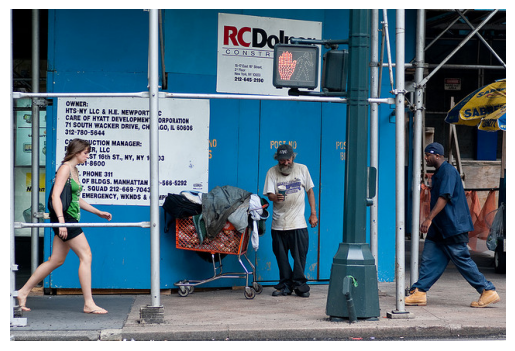

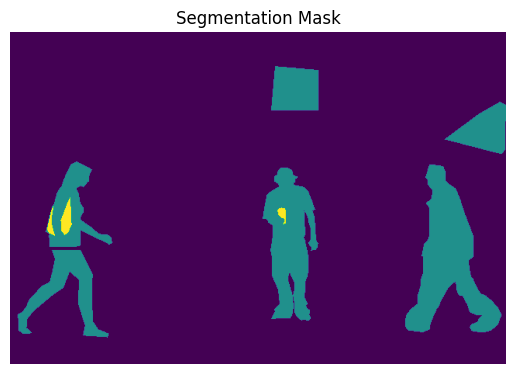

In [ ]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

annotation_file = 'data/raw/annotations.json'  # use instances_val2017.json or train2017
image_dir = 'data/raw/images'

coco = COCO(annotation_file)

image_id = 252219
img_info = coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image_dir, img_info['file_name']))
plt.imshow(image)
plt.axis('off')
plt.show()


cat_ids = coco.getCatIds()
ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(ann_ids)

# Composite mask (multiclass-style)
mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
for ann in anns:
    mask += coco.annToMask(ann)

plt.imshow(mask)
plt.axis('off')
plt.title("Segmentation Mask")
plt.show()

In [21]:
image_ids = coco.getImgIds()
print(f"Number of images in annotation: {len(image_ids)}")
print("First 5 image IDs:", image_ids[:5])

Number of images in annotation: 5000
First 5 image IDs: [397133, 37777, 252219, 87038, 174482]


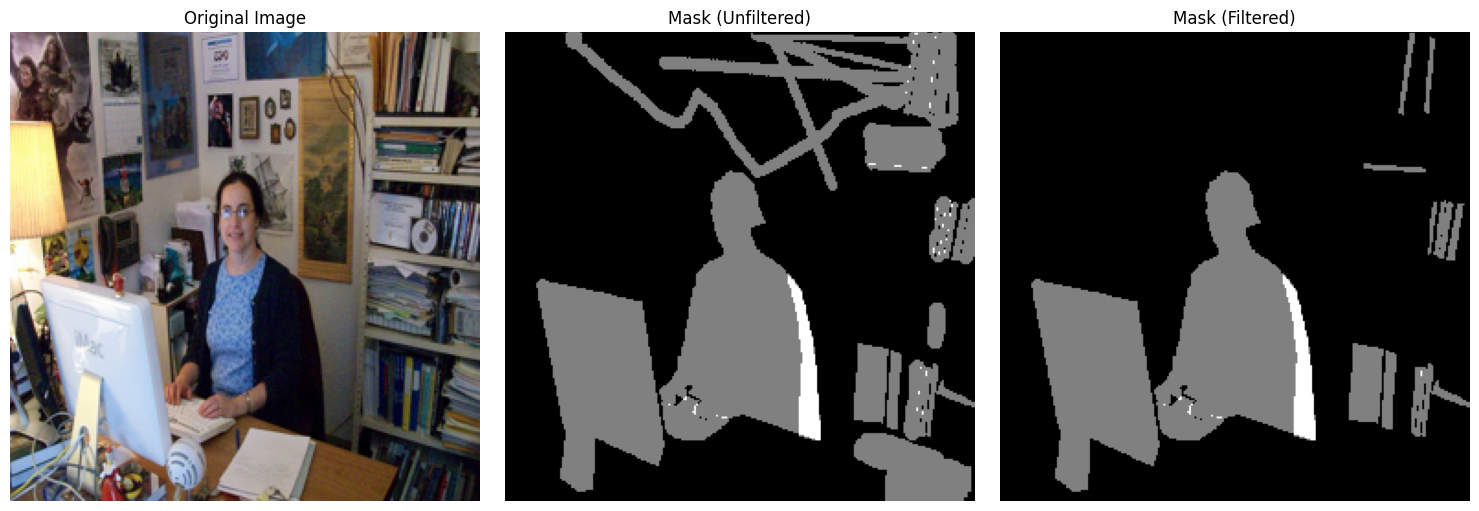

In [ ]:
# Check | Why it matters
# 'segmentation' in ann | Some annotations don't include segmentation data (e.g., for captions, keypoints).
# ann['segmentation']   | Filters out empty polygons.
# isinstance(..., list) | Skips RLE (Run-Length Encoding) which we aren't handling here.
# category_id in catIds | Ensures category is known and supported.

def is_valid_annotation(ann, coco):
    return (
        'segmentation' in ann and ann['segmentation'] and
        isinstance(ann['segmentation'], list) and
        ann['category_id'] in coco.getCatIds()
    )



# Pick one image ID
img_id = coco.getImgIds()[11]
img_info = coco.loadImgs(img_id)[0]
file_name = img_info['file_name']
img_path = os.path.join(image_dir, file_name)

# Load image
image = Image.open(img_path).convert("RGB").resize((256, 256))

# Load all annotations
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Mask WITHOUT filtering
raw_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
for ann in anns:
    raw_mask += coco.annToMask(ann)
raw_mask = Image.fromarray(raw_mask).resize((256, 256), resample=Image.NEAREST)

# Mask WITH filtering
filtered_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
for ann in anns:
    if not is_valid_annotation(ann, coco):
        continue
    filtered_mask += coco.annToMask(ann)
filtered_mask = Image.fromarray(filtered_mask).resize((256, 256), resample=Image.NEAREST)



import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(raw_mask, cmap='gray')
plt.title("Mask (Unfiltered)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(filtered_mask, cmap='gray')
plt.title("Mask (Filtered)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [65]:
coco.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

/tmp/ipykernel_3298998/2494064056.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(cat_ids_used))


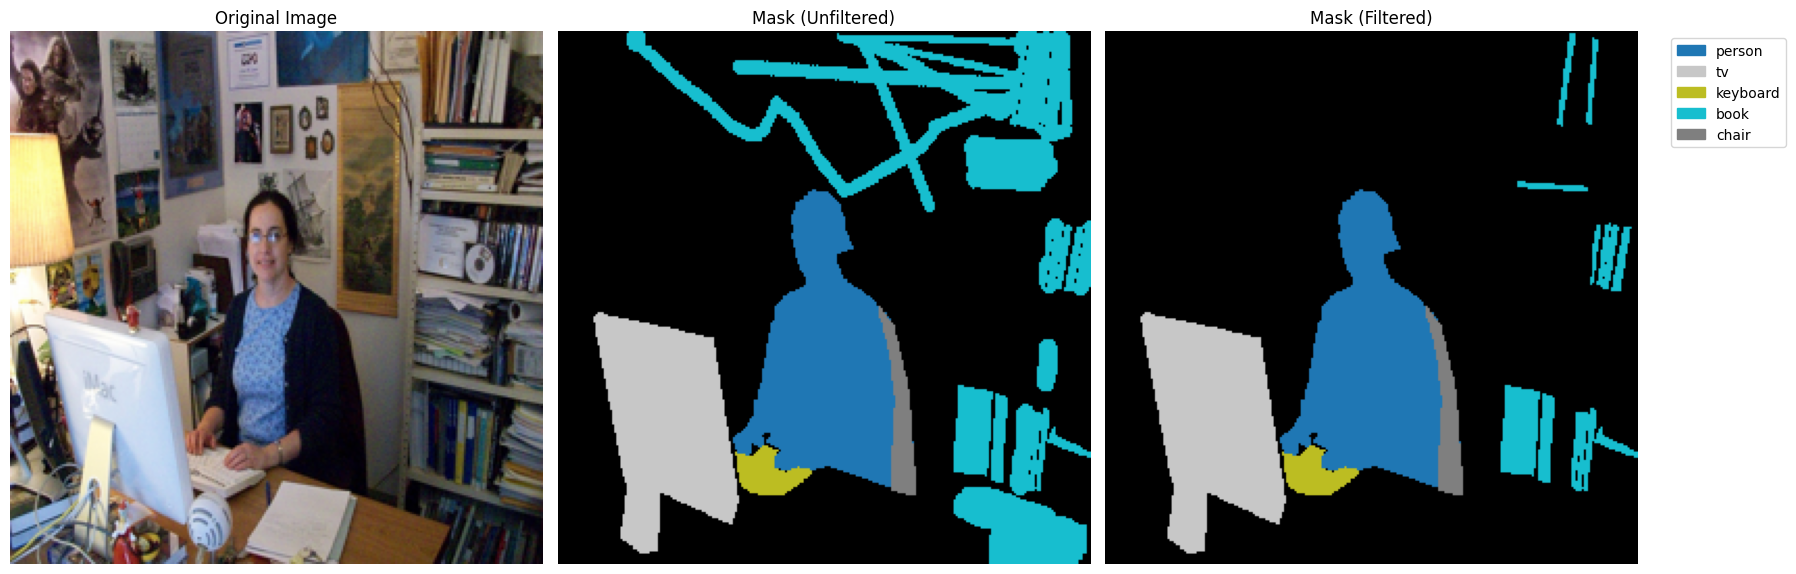

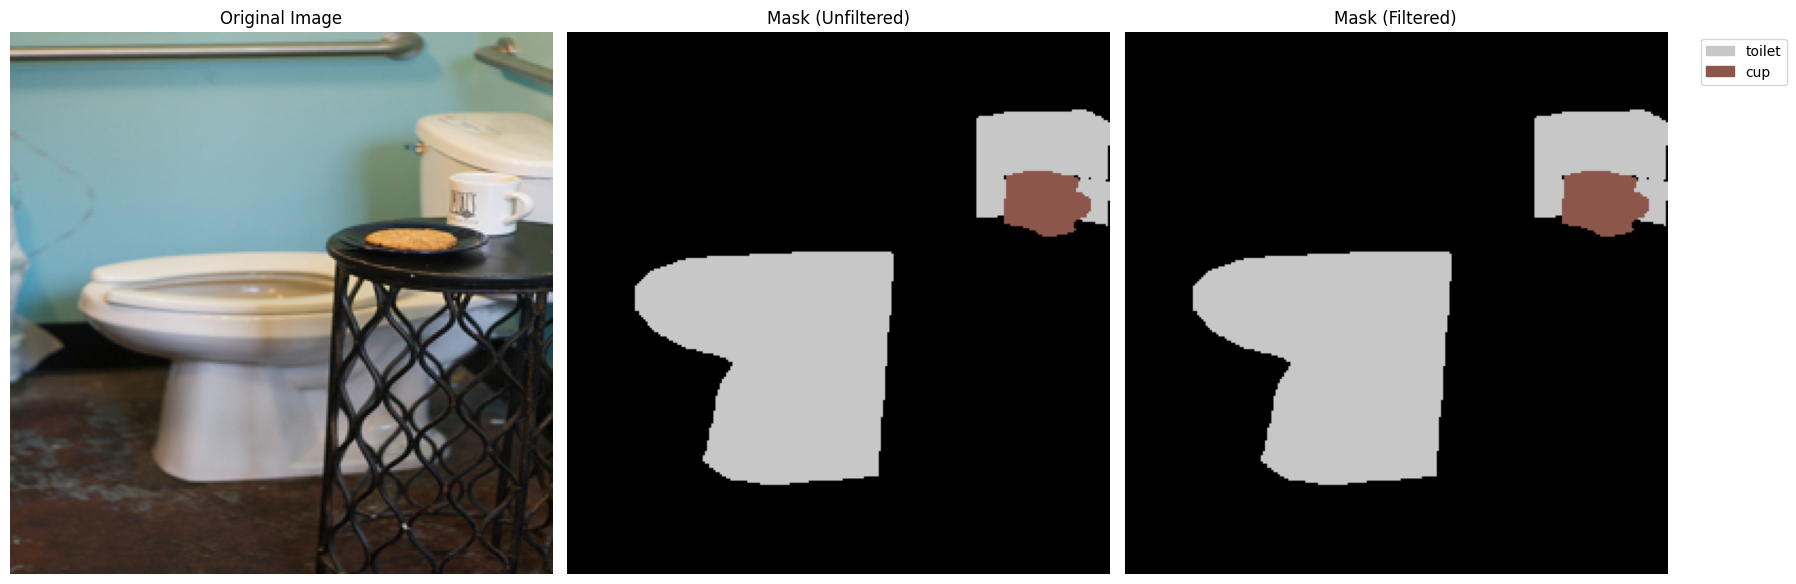

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

    # --- Step 1: Prepare original image ---
for ids in [11,141]:

    img_id = coco.getImgIds()[ids]
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = os.path.join(image_dir, file_name)
    image = Image.open(img_path).convert("RGB").resize((256, 256))

    # --- Step 2: Create color map ---
    cats = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {cat['id']: cat['name'] for cat in cats}
    cat_ids_used = list(cat_id_to_name.keys())

    colormap = plt.cm.get_cmap('tab20', len(cat_ids_used))
    cat_id_to_color = {cat_id: colormap(i) for i, cat_id in enumerate(cat_ids_used)}

    # --- Step 3: Generate masks (unfiltered vs filtered) ---
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

    def build_colored_mask(anns, filter_invalid=True):
        h, w = img_info['height'], img_info['width']
        mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        used_ids = set()
        
        for ann in anns:
            if filter_invalid and not is_valid_annotation(ann, coco):
                continue
            cat_id = ann['category_id']
            color = (np.array(cat_id_to_color[cat_id][:3]) * 255).astype(np.uint8)
            region = coco.annToMask(ann).astype(bool)
            for i in range(3):
                mask_rgb[..., i][region] = color[i]
            used_ids.add(cat_id)
        
        return Image.fromarray(mask_rgb).resize((256, 256), resample=Image.NEAREST), used_ids

    unfiltered_mask, used_unfiltered = build_colored_mask(anns, filter_invalid=False)
    filtered_mask, used_filtered = build_colored_mask(anns, filter_invalid=True)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(unfiltered_mask)
    plt.title("Mask (Unfiltered)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(filtered_mask)
    plt.title("Mask (Filtered)")
    plt.axis("off")

    # Legend
    all_used_ids = used_unfiltered.union(used_filtered)
    handles = [
        mpatches.Patch(color=cat_id_to_color[cat_id], label=cat_id_to_name[cat_id])
        for cat_id in all_used_ids
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# We implemented a validation check to filter out annotations with empty, malformed, or unsupported 
# segmentation data. This improved the quality of the segmentation masks by excluding noise and 
# ensuring all mask regions correspond to valid COCO object classes. A visual comparison between 
# unfiltered and filtered masks clearly highlights the benefit of this step.

# Process all valid images and store them

In [61]:
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import os
from tqdm.notebook import tqdm

# --- Set Paths ---
annotation_file = 'data/raw/annotations.json'
image_dir = 'data/raw/images'
out_image_dir = 'data/processed/images'
out_mask_dir = 'data/processed/masks'

os.makedirs(out_image_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

# --- Load COCO ---
coco = COCO(annotation_file)
image_ids = coco.getImgIds()
cat_ids = coco.getCatIds()

# --- Filter Check ---
def is_valid_annotation(ann, coco):
    return (
        'segmentation' in ann and ann['segmentation'] and
        isinstance(ann['segmentation'], list) and
        ann['category_id'] in coco.getCatIds()
    )

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [62]:
max_images = 6000
resize_dim = 256
processed = 0

for img_id in tqdm(image_ids):
    if processed >= max_images:
        break

    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = os.path.join(image_dir, file_name)

    if not os.path.exists(img_path):
        continue

    try:
        # Load and resize image
        image = Image.open(img_path).convert("RGB").resize((resize_dim, resize_dim))
        image.save(os.path.join(out_image_dir, file_name))

        # Create multi-class mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            if not is_valid_annotation(ann, coco):
                continue
            ann_mask = coco.annToMask(ann)
            mask[ann_mask == 1] = ann['category_id']

        # Resize and save mask
        mask = Image.fromarray(mask).resize((resize_dim, resize_dim), resample=Image.NEAREST)
        mask.save(os.path.join(out_mask_dir, file_name))

        processed += 1

    except Exception as e:
        print(f"[WARNING] Skipping {file_name} due to error: {e}")

  0%|          | 0/5000 [00:00<?, ?it/s]

# Preview Randomly Saved Image–Mask Pairs

In [63]:
import random
import matplotlib.pyplot as plt

def preview_samples(image_dir, mask_dir, num_samples=5):
    file_names = os.listdir(image_dir)
    chosen_files = random.sample(file_names, min(num_samples, len(file_names)))

    plt.figure(figsize=(12, 4 * num_samples))
    
    for i, file_name in enumerate(chosen_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        # Plot side by side
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image)
        plt.title(f"Image: {file_name}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap='tab20')  # shows class IDs in color
        plt.title("Segmentation Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

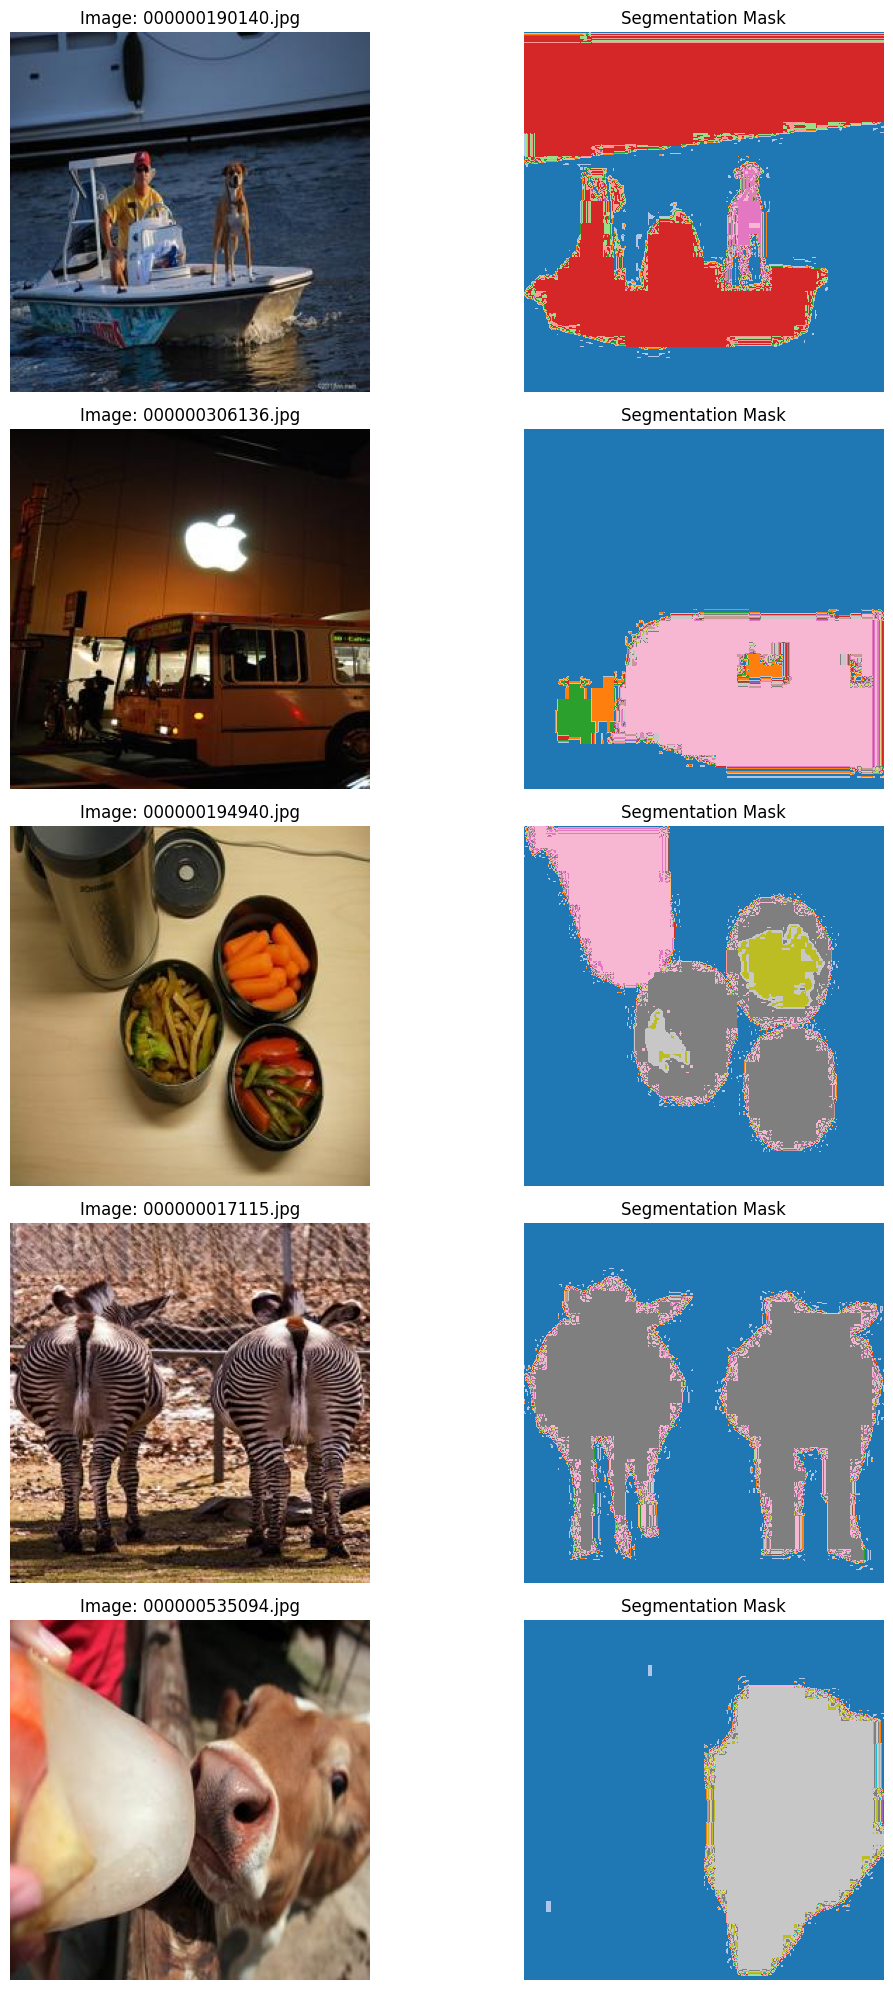

In [64]:
preview_samples("data/processed/images", "data/processed/masks", num_samples=5)